In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
])

In [ ]:
#Dataloader

#Path for training and testing directory
train_path='/content/drive/MyDrive/Leaf_dataset/plant_image_dataset/Train'
test_path='/content/drive/MyDrive/Leaf_dataset/plant_image_dataset/Test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
print(classes)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soyabean', 'Strawberry', 'Tomato']


In [ ]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            

In [ ]:
model=ConvNet(num_classes=12).to(device)

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

In [ ]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [ ]:
print(train_count,test_count)

242 103


In [ ]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cuda().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'/content/drive/MyDrive/Leaf_dataset/best_checkpoint.model')
        best_accuracy=test_accuracy
    

Epoch: 0 Train Loss: tensor(33.2146, device='cuda:0') Train Accuracy: 10.15702479338843 Test Accuracy: 9.320388349514563
Epoch: 1 Train Loss: tensor(22.0432, device='cuda:0') Train Accuracy: 10.640495867768594 Test Accuracy: 10.912621359223301
Epoch: 2 Train Loss: tensor(14.9565, device='cuda:0') Train Accuracy: 11.086776859504132 Test Accuracy: 10.640776699029127
Epoch: 3 Train Loss: tensor(8.3016, device='cuda:0') Train Accuracy: 11.516528925619834 Test Accuracy: 10.970873786407767
Epoch: 4 Train Loss: tensor(8.8894, device='cuda:0') Train Accuracy: 11.433884297520661 Test Accuracy: 11.0
Epoch: 5 Train Loss: tensor(4.8658, device='cuda:0') Train Accuracy: 11.74793388429752 Test Accuracy: 10.922330097087379
Epoch: 6 Train Loss: tensor(3.0971, device='cuda:0') Train Accuracy: 11.809917355371901 Test Accuracy: 10.631067961165048
Epoch: 7 Train Loss: tensor(3.7922, device='cuda:0') Train Accuracy: 11.826446280991735 Test Accuracy: 11.359223300970873
Epoch: 8 Train Loss: tensor(4.0171, de

Prediction

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

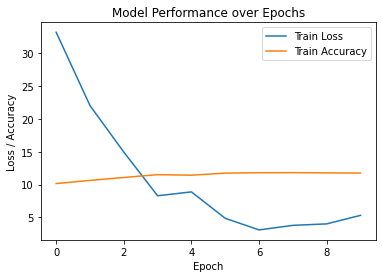

In [ ]:
import matplotlib.pyplot as plt

# Create lists to store the train loss, train accuracy, and test accuracy data
train_loss = [33.2146, 22.0432, 14.9565, 8.3016, 8.8894, 4.8658, 3.0971, 3.7922, 4.0171, 5.3175]
train_acc = [10.15702479338843, 10.640495867768594, 11.086776859504132, 11.516528925619834, 11.433884297520661, 11.74793388429752, 11.809917355371901, 11.826446280991735, 11.789256198347108, 11.760330578512397]
test_acc = [9.320388349514563, 10.912621359223301, 10.640776699029127, 10.970873786407767, 11.0, 10.922330097087379, 10.631067961165048, 11.359223300970873, 10.893203883495145]

# Create a list of epoch numbers
epochs = list(range(len(train_loss)))

def plot(func):
    plt.figure(figsize=(12, 8))
    x = np.linspace(-100, 100, 100)
    plt.plot(x, func, '-', color='pink')
    plt.show()
    plt.close()

# Create the plot
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Train Loss')
ax.plot(epochs, train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add titles and labels to the plot
ax.set_title('Model Performance over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / Accuracy')
ax.legend()

# Show the plot
plt.show()


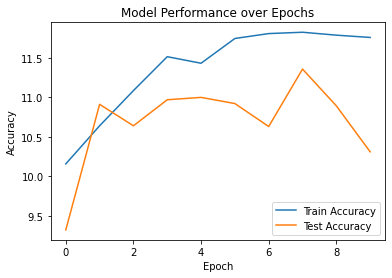

In [ ]:
import matplotlib.pyplot as plt

train_acc = [10.157, 10.640, 11.086, 11.516, 11.433, 11.747, 11.809, 11.826, 11.789, 11.760]
test_acc = [9.320, 10.912, 10.640, 10.970, 11.000, 10.922, 10.631, 11.359, 10.893, 10.310]

epochs = range(10)

# Create the plot
fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label='Train Accuracy')
ax.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add titles and labels to the plot
ax.set_title('Model Performance over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Show the plot
plt.show()

# plt.plot(epochs, train_acc, label='Train Accuracy')
# plt.plot(epochs, test_acc, label='Test Accuracy')

# fig, ax = plt.subplots()
# ax.set_title('Model Performance over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
